In [1]:
import pickle
import pandas as pd
import numpy as np
from typing import List, Dict, Tuple
from itertools import combinations_with_replacement
import matplotlib.pyplot as plt

In [2]:
print("Ładowanie modeli i danych...")
with open("ig_best_models_by_circuit.pickle", "rb") as f:
    models = pickle.load(f)

with open("ig_dfs_by_circuit.pickle", "rb") as f:
    data = pickle.load(f)

available_circuits = list(models.keys())
print(f"Załadowano modele dla {len(available_circuits)} torów:")
print(available_circuits)

Ładowanie modeli i danych...


/var/folders/yc/v_qb89hd41vfn0lk4xxjlp_r0000gp/T/ipykernel_23644/2601540922.py:3: UserWarning: [01:18:15] WARNING: /Users/runner/work/xgboost/xgboost/src/gbm/../common/error_msg.h:83: If you are loading a serialized model (like pickle in Python, RDS in R) or
configuration generated by an older version of XGBoost, please export the model by calling
`Booster.save_model` from that version first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/stable/tutorials/saving_model.html

for more details about differences between saving model and serializing.

  models = pickle.load(f)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DummyRegressor from version 1.7.1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#securit

Załadowano modele dla 22 torów:
['Miami', 'Austin', 'Melbourne', 'Las Vegas', 'Mexico City', 'Jeddah', 'Yas Marina Circuit', 'Sakhir', 'Singapore', 'Imola', 'Montreal', 'Spa-Francorchamps', 'Paul Ricard', 'Silverstone', 'Baku', 'Spielberg', 'Monza', 'Suzuka', 'Catalunya', 'Zandvoort', 'Monte Carlo', 'Hungaroring']


In [3]:
def get_race_laps(circuit: str) -> int:
    RACE_LAPS = {
        'Austin': 56,
    }
    
    if circuit not in RACE_LAPS:
        print(f"Brak danych o liczbie okrążeń dla {circuit}, używam domyślnie 56")
        return 56
    
    return RACE_LAPS[circuit]

In [4]:
def generate_strategies(total_laps: int, min_stops: int = 1,
                       max_stops: int = 3) -> List[List[int]]:
    strategies = []

    min_stint_length = 8
    max_stint_length = 35
    earliest_stop = 8
    latest_stop = total_laps - 8

    possible_laps = list(range(earliest_stop, latest_stop + 1))

    for num_stops in range(min_stops, max_stops + 1):
        for strategy in combinations_with_replacement(possible_laps, num_stops):
            strategy_list = sorted(list(strategy))

            valid = True

            prev_stop = 0
            for stop in strategy_list:
                if stop - prev_stop < min_stint_length:
                    valid = False
                    break
                if stop - prev_stop > max_stint_length:
                    valid = False
                    break
                prev_stop = stop

            if valid and (total_laps - strategy_list[-1]) < min_stint_length:
                valid = False
            if valid and (total_laps - strategy_list[-1]) > max_stint_length:
                valid = False

            if valid and strategy_list not in strategies:
                strategies.append(strategy_list)

    return strategies

In [5]:
def prepare_lap_features(lap_number: int, stint_lap: int,
                         compound: str, circuit: str,
                         air_temp: float = None,
                         track_temp: float = None,
                         humidity: float = None,
                         rainfall: bool = False,
                         pressure: float = None,
                         wind_speed: float = None,
                         wind_direction: float = None) -> pd.DataFrame:
    sample_data = data[circuit]

    features = pd.DataFrame({
        'LapNumber': [lap_number],
        'TyreLife': [stint_lap],
        'FreshTyre': [1 if stint_lap == 1 else 0],
        'IsPitLap': [0],
    })

    features['AirTemp'] = air_temp if air_temp is not None else sample_data['AirTemp'].median()
    features['TrackTemp'] = track_temp if track_temp is not None else sample_data['TrackTemp'].median()
    features['Humidity'] = humidity if humidity is not None else sample_data['Humidity'].median()
    features['Pressure'] = pressure if pressure is not None else sample_data['Pressure'].median()
    features['Rainfall'] = 1 if rainfall else 0
    features['WindSpeed'] = wind_speed if wind_speed is not None else sample_data['WindSpeed'].median()
    features['WindDirection'] = wind_direction if wind_direction is not None else sample_data['WindDirection'].median()

    features['Compound_HARD'] = 1 if compound == 'HARD' else 0
    features['Compound_MEDIUM'] = 1 if compound == 'MEDIUM' else 0
    features['Compound_SOFT'] = 1 if compound == 'SOFT' else 0

    required_cols = [col for col in sample_data.columns if col != 'LapTimeZScore']

    for col in required_cols:
        if col not in features.columns:
            if sample_data[col].dtype in ['int64', 'float64']:
                features[col] = sample_data[col].median()
            else:
                features[col] = sample_data[col].mode()[0] if len(sample_data[col].mode()) > 0 else 0

    return features[required_cols]

In [6]:
def simulate_strategy(strategy: List[int], total_laps: int,
                      circuit: str, compounds: List[str] = None,
                      air_temp: float = None,
                      track_temp: float = None,
                      humidity: float = None,
                      rainfall: bool = False,
                      pressure: float = None,
                      wind_speed: float = None,
                      wind_direction: float = None) -> Tuple[float, pd.DataFrame]:
    if circuit not in models:
        raise ValueError(f"Brak modelu dla toru: {circuit}")

    model = models[circuit]

    if compounds is None:
        num_stints = len(strategy) + 1
        if num_stints == 2:
            compounds = ['HARD', 'MEDIUM']
        elif num_stints == 3:
            compounds = ['MEDIUM', 'HARD', 'MEDIUM']
        elif num_stints == 4:
            compounds = ['SOFT', 'MEDIUM', 'MEDIUM', 'SOFT']
        else:
            compounds = ['MEDIUM'] * num_stints

    if len(compounds) != len(strategy) + 1:
        raise ValueError(f"Liczba mieszanek ({len(compounds)}) != liczba stintów ({len(strategy) + 1})")

    pit_stops = set(strategy)
    results = []

    current_stint = 0
    stint_lap = 1

    for lap in range(1, total_laps + 1):
        if lap in pit_stops:
            current_stint += 1
            stint_lap = 1

        lap_features = prepare_lap_features(
            lap_number=lap,
            stint_lap=stint_lap,
            compound=compounds[current_stint],
            circuit=circuit,
            air_temp=air_temp,
            track_temp=track_temp,
            humidity=humidity,
            rainfall=rainfall,
            pressure=pressure,
            wind_speed=wind_speed,
            wind_direction=wind_direction
        )

        predicted_zscore = model.predict(lap_features)[0]

        results.append({
            'LapNumber': lap,
            'Stint': current_stint + 1,
            'StintLap': stint_lap,
            'TyreLife': stint_lap,
            'Compound': compounds[current_stint],
            'PredictedZScore': predicted_zscore,
            'IsPitStop': lap in pit_stops
        })

        stint_lap += 1

    results_df = pd.DataFrame(results)
    mean_zscore = results_df['PredictedZScore'].mean()

    return mean_zscore, results_df

In [7]:
def get_compound_combinations(num_stints: int) -> List[List[str]]:
    if num_stints == 2:
        return [
            ['HARD', 'MEDIUM'],
            ['MEDIUM', 'SOFT'],
            ['HARD', 'SOFT'],
            ['SOFT', 'MEDIUM'],
            ['MEDIUM', 'MEDIUM'],
            ['SOFT', 'SOFT'],
        ]
    elif num_stints == 3:
        return [
            ['SOFT', 'MEDIUM', 'SOFT'],
            ['MEDIUM', 'HARD', 'MEDIUM'],
            ['HARD', 'MEDIUM', 'SOFT'],
            ['SOFT', 'SOFT', 'MEDIUM'],
            ['MEDIUM', 'MEDIUM', 'SOFT'],
            ['HARD', 'HARD', 'MEDIUM'],
            ['MEDIUM', 'SOFT', 'SOFT'],
        ]
    elif num_stints == 4:
        return [
            ['SOFT', 'MEDIUM', 'MEDIUM', 'SOFT'],
            ['MEDIUM', 'HARD', 'MEDIUM', 'SOFT'],
            ['SOFT', 'SOFT', 'MEDIUM', 'SOFT'],
            ['SOFT', 'MEDIUM', 'SOFT', 'SOFT'],
        ]
    else:
        return [['MEDIUM'] * num_stints]

In [8]:
def optimize_strategy(total_laps: int, circuit: str,
                      min_stops: int = 1, max_stops: int = 3,
                      air_temp: float = None,
                      track_temp: float = None,
                      humidity: float = None,
                      rainfall: bool = False,
                      pressure: float = None,
                      wind_speed: float = None,
                      wind_direction: float = None,
                      top_n: int = 5,
                      test_all_compounds: bool = False) -> pd.DataFrame:
    print(f"\n{'=' * 60}")
    print(f"OPTYMALIZACJA STRATEGII DLA: {circuit}")
    print(f"{'=' * 60}")
    print(f"Liczba okrążeń: {total_laps}")
    print(f"Zakres pit stopów: {min_stops}-{max_stops}")

    strategies = generate_strategies(total_laps, min_stops, max_stops)
    print(f"Wygenerowano {len(strategies)} strategii do przetestowania\n")

    strategy_results = []

    for i, strategy in enumerate(strategies):
        if (i + 1) % 50 == 0:
            print(f"  Przetworzone {i + 1}/{len(strategies)} strategii...")

        if test_all_compounds:
            num_stints = len(strategy) + 1
            compound_combinations = get_compound_combinations(num_stints)

            best_zscore = float('inf')
            best_compounds = None

            for compounds in compound_combinations:
                mean_zscore, _ = simulate_strategy(
                    strategy=strategy,
                    total_laps=total_laps,
                    circuit=circuit,
                    compounds=compounds,
                    air_temp=air_temp,
                    track_temp=track_temp,
                    humidity=humidity,
                    rainfall=rainfall,
                    pressure=pressure,
                    wind_speed=wind_speed,
                    wind_direction=wind_direction
                )

                if mean_zscore < best_zscore:
                    best_zscore = mean_zscore
                    best_compounds = compounds

            strategy_results.append({
                'Strategy': strategy,
                'Compounds': best_compounds,
                'NumStops': len(strategy),
                'MeanZScore': best_zscore
            })
        else:
            mean_zscore, _ = simulate_strategy(
                strategy=strategy,
                total_laps=total_laps,
                circuit=circuit,
                air_temp=air_temp,
                track_temp=track_temp,
                humidity=humidity,
                rainfall=rainfall,
                pressure=pressure,
                wind_speed=wind_speed,
                wind_direction=wind_direction
            )

            strategy_results.append({
                'Strategy': strategy,
                'NumStops': len(strategy),
                'MeanZScore': mean_zscore
            })

    results_df = pd.DataFrame(strategy_results)
    results_df = results_df.sort_values('MeanZScore').reset_index(drop=True)
    results_df['ZScoreDelta'] = results_df['MeanZScore'] - results_df['MeanZScore'].iloc[0]

    print(f"\n✓ Optymalizacja zakończona!\n")
    return results_df.head(top_n)

In [9]:
def plot_simulation(simulation_df, strategy, compounds, circuit):
    plt.figure(figsize=(14, 6))

    plt.plot(simulation_df['LapNumber'], simulation_df['PredictedZScore'],
             label="Przewidywany z-score", color="blue", linewidth=2)

    pit_laps = simulation_df[simulation_df['IsPitStop']]['LapNumber']
    for lap in pit_laps:
        plt.axvline(lap, color="red", linestyle="--", alpha=0.7, 
                   label="Pit stop" if lap == pit_laps.iloc[0] else "")

    colors = {'SOFT': 'red', 'MEDIUM': 'yellow', 'HARD': 'white'}
    for stint in simulation_df['Stint'].unique():
        stint_data = simulation_df[simulation_df['Stint'] == stint]
        compound = stint_data['Compound'].iloc[0]
        plt.axvspan(stint_data['LapNumber'].iloc[0] - 0.5,
                    stint_data['LapNumber'].iloc[-1] + 0.5,
                    alpha=0.2,
                    color=colors.get(compound, 'gray'),
                    label=f'Stint {stint} ({compound})')

    plt.xlabel("Okrążenie", fontsize=12)
    plt.ylabel("Z-score", fontsize=12)
    plt.title(f"Strategia {strategy} | {compounds} | {circuit}", fontsize=14, fontweight='bold')
    plt.legend(loc='best')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()



OPTYMALIZACJA STRATEGII DLA: Austin
Liczba okrążeń: 56
Zakres pit stopów: 1-2
Wygenerowano 531 strategii do przetestowania

  Przetworzone 50/531 strategii...
  Przetworzone 100/531 strategii...
  Przetworzone 150/531 strategii...
  Przetworzone 200/531 strategii...
  Przetworzone 250/531 strategii...
  Przetworzone 300/531 strategii...
  Przetworzone 350/531 strategii...
  Przetworzone 400/531 strategii...
  Przetworzone 450/531 strategii...
  Przetworzone 500/531 strategii...

✓ Optymalizacja zakończona!


TOP 10 NAJLEPSZYCH STRATEGII
Strategy  NumStops  MeanZScore  ZScoreDelta
    [24]         1    1.579385     0.000000
    [35]         1    1.581795     0.002410
    [34]         1    1.583003     0.003617
    [23]         1    1.584434     0.005049
    [33]         1    1.584657     0.005272
    [32]         1    1.587718     0.008333
    [25]         1    1.588148     0.008763
    [31]         1    1.589262     0.009877
    [30]         1    1.590806     0.011421
    [22]        

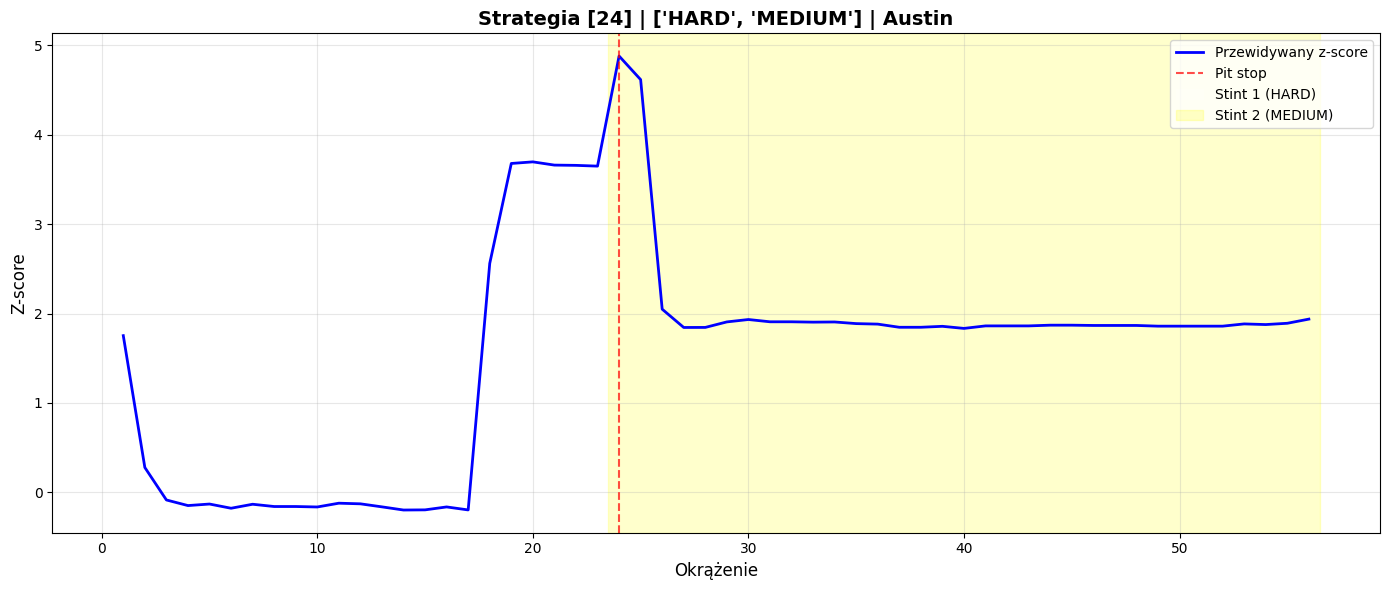

In [10]:
circuit_name = 'Austin'
race_laps = get_race_laps(circuit_name)

best_strategies = optimize_strategy(
    total_laps=race_laps,
    circuit=circuit_name,
    min_stops=1,
    max_stops=2,
    air_temp=33.3,
    track_temp=45.0,
    humidity=30,
    rainfall=False,
    pressure=1012,
    wind_speed=7,
    wind_direction=165,
    top_n=10,
    test_all_compounds=False
)

print("\n" + "=" * 60)
print("TOP 10 NAJLEPSZYCH STRATEGII")
print("=" * 60)
print(best_strategies.to_string(index=False))

best_strategy = best_strategies.iloc[0]['Strategy']
print(f"\nSzczegółowa analiza najlepszej strategii: {best_strategy}")

mean_zscore, detailed_sim = simulate_strategy(
    strategy=best_strategy,
    total_laps=race_laps,
    circuit=circuit_name,
    air_temp=33.3,
    track_temp=45.0,
    humidity=30,
    rainfall=False,
    pressure=1012,
    wind_speed=7,
    wind_direction=165
)

print(f"\nŚredni z-score: {mean_zscore:.6f}")
print(f"\nStatystyki z-score dla stintów:")
for stint in detailed_sim['Stint'].unique():
    stint_data = detailed_sim[detailed_sim['Stint'] == stint]
    print(f"  Stint {stint} ({stint_data['Compound'].iloc[0]}): "
          f"średni z-score = {stint_data['PredictedZScore'].mean():.6f}, "
          f"okrążeń = {len(stint_data)}")

plot_simulation(detailed_sim, best_strategy, 
                [detailed_sim[detailed_sim['Stint']==s]['Compound'].iloc[0] 
                 for s in detailed_sim['Stint'].unique()],
                circuit_name)